# Data Science in Economics and Business - Class Project
In this class project, you are supposed to work with GDP data taken from the International Monetary Fund.

**IMPORTANT:** <br>
Please enter the matriculation number of all group members here:
1. XXXXXX
2. YYYYYY
3. ZZZZZZ

API key: S4fKTjESiijBFS7URg8z

In this class project, you will use the different techniques taught in the course: data handling, data visualization, and machine learning.

First load the necessary packages. <br>
If you want to use additional libraries you can add them to the following cell:

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import world_bank_data as wb
import wbgapi as wba
import datetime
sns.set()
import folium
from folium.plugins import MarkerCluster

In [165]:
#Little test with wbgapi, to build directly a dataframe
# https://nbviewer.org/github/tgherzog/wbgapi/blob/master/examples/wbgapi-cookbook.ipynb
wba.data.DataFrame(['SP.POP.TOTL', 'NY.GDP.PCAP.CD'],
                  time=range(2010,2015), skipBlanks=True, columns='series')

NY.GDP.PCAP.CD  SP.POP.TOTL
economy time                               
ABW     YR2010    24452.928363     100341.0
        YR2011    26044.435933     101288.0
        YR2012    25609.955724     102112.0
        YR2013    26515.678080     102880.0
        YR2014    26942.307976     103594.0
...                        ...          ...
ZWE     YR2010      937.840340   12839771.0
        YR2011     1082.615773   13025785.0
        YR2012     1290.193957   13265331.0
        YR2013     1408.367810   13555422.0
        YR2014     1407.034291   13855753.0

[1325 rows x 2 columns]

In [166]:
#Get countries from World Bank API and drop unnecessary data
countries = wb.get_countries()
countries = countries[countries['incomeLevel'] != 'Aggregates'].rename(columns={'name': 'countryName'})
countries.drop(['iso2Code', 'adminregion', 'capitalCity', 'lendingType', 'longitude', 'latitude'], axis=1, inplace=True)
countries

,countryName,region,incomeLevel
id,,,
ABW,Aruba,Latin America & Caribbean,High income
AFG,Afghanistan,South Asia,Low income
AGO,Angola,Sub-Saharan Africa,Lower middle income
ALB,Albania,Europe & Central Asia,Upper middle income
AND,Andorra,Europe & Central Asia,High income
...,...,...,...
XKX,Kosovo,Europe & Central Asia,Upper middle income
YEM,"Yemen, Rep.",Middle East & North Africa,Low income
ZAF,South Africa,Sub-Saharan Africa,Upper middle income


In [167]:
current_year = datetime.datetime.now().year

In [168]:
LABOR_FORCE_PARTICIPATION = wb.get_series('SL.TLF.CACT.NE.ZS', id_or_value="id", simplify_index=True, date='1994:'+str(current_year))
LABOR_FORCE_PARTICIPATION

Country  Year
AFE      1994      NaN
         1995      NaN
         1996      NaN
         1997      NaN
         1998      NaN
                 ...  
ZWE      2018      NaN
         2019    65.79
         2020      NaN
         2021    65.40
         2022      NaN
Name: SL.TLF.CACT.NE.ZS, Length: 7714, dtype: float64

In [198]:
data_series_dict = {
    'labor_force_participation': 'SL.TLF.CACT.NE.ZS',
    'unemployment_total': 'SL.UEM.TOTL.ZS',
    'rural_population': 'SP.RUR.TOTL',
    'rural_population_percent': 'SP.RUR.TOTL.ZS',
    'ratio_female_male_labor_force': 'SL.TLF.CACT.FM.ZS',
    'gini_index': 'SI.POV.GINI',
    'poverty_headcount_ratio': 'SI.POV.DDAY',
    'ghg_emissions': 'EN.ATM.GHGT.ZG',
    'urban_population_growth': 'SP.URB.GROW',
    'under_5_mortality': 'SH.DYN.MORT',
    'net_official_development_aid': 'DT.ODA.ALLD.CD',
    'net_migration': 'SM.POP.NETM',
    'access_to_electricity': 'EG.ELC.ACCS.ZS',
    'energy_use': 'EG.USE.PCAP.KG.OE',
    'population_growth': 'SP.POP.GROW',
    'adjusted_net_income': 'NY.ADJ.NNTY.CD',
    'school_enrollment': 'SE.PRE.ENRR',
    'government_debt': 'GC.DOD.TOTL.GD.ZS',
    'maternal_death_risk': 'SH.MMR.RISK.ZS',
    'inflation': 'FP.CPI.TOTL.ZG',
    'age_dependency_ratio': 'SP.POP.DPND',
    'birth_rate': 'SP.DYN.CBRT.IN',
    'death_rate': 'SP.DYN.CDRT.IN',
    'hospital_beds': 'SH.MED.BEDS.ZS',
    'logistics_performance_index': 'LP.LPI.OVRL.XQ',
    'tariff_rate': 'TM.TAX.MRCH.SM.AR.ZS',
    'total_labor_force': 'SL.TLF.TOTL.IN',
    'armed_forces_personnel': 'MS.MIL.TOTL.P1',
    'human_capital_index': 'HD.HCI.OVRL',
    'trade_percent_gdp': 'NE.TRD.GNFS.ZS',
    'female_suicide_rate': 'SH.STA.SUIC.FE.P5',
    'secure_internet_servers': 'IT.NET.SECR',
    'new_businesses_registered': 'IC.BUS.NREG',
    'patent_applications': 'IP.PAT.RESD'
}

df = pd.DataFrame()

for var_name, series_name in data_series_dict.items():
    #Get series with the dict
    data_series = wb.get_series(series_name, date='1994:'+str(current_year), id_or_value='id')

    # Reset index, drop 'Series' column, and rename the series column
    data_series_df = data_series.reset_index().drop(columns=['Series'])
    data_series_df.rename(columns={series_name: var_name}, inplace=True)

    # If result DataFrame is empty, copy the current data
    if df.empty:
        df = data_series_df.copy()
    else:
        # Otherwise merge current data with existing DataFrame
        df = pd.merge(df, data_series_df, on=['Country', 'Year'], how='outer')
df

,Country,Year,labor_force_participation,unemployment_total,rural_population,rural_population_percent,ratio_female_male_labor_force,gini_index,poverty_headcount_ratio,ghg_emissions,...,logistics_performance_index,tariff_rate,total_labor_force,armed_forces_personnel,human_capital_index,trade_percent_gdp,female_suicide_rate,secure_internet_servers,new_businesses_registered,patent_applications
0,AFE,1994,NaN,7.160694,251602062.0,73.051291,83.236716,NaN,NaN,NaN,...,NaN,NaN,134181053.0,794000.0,NaN,47.256914,NaN,NaN,NaN,NaN
1,AFE,1995,NaN,7.063796,256845485.0,72.664712,83.825490,NaN,NaN,NaN,...,NaN,NaN,138169361.0,1342300.0,NaN,49.319926,NaN,NaN,NaN,NaN
2,AFE,1996,NaN,7.055998,262711347.0,72.375103,84.102386,NaN,NaN,NaN,...,NaN,NaN,141973175.0,1296000.0,NaN,48.747941,NaN,NaN,NaN,NaN
3,AFE,1997,NaN,7.090541,268424729.0,72.088928,84.339786,NaN,NaN,NaN,...,NaN,NaN,145688984.0,1248390.0,NaN,46.427172,NaN,NaN,NaN,NaN
4,AFE,1998,NaN,7.060096,274058918.0,71.796625,84.605244,NaN,NaN,NaN,...,NaN,NaN,149656118.0,1284350.0,NaN,47.200993,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7709,ZWE,2018,NaN,6.784000,10204026.0,67.791000,84.069558,NaN,NaN,NaN,...,2.12,NaN,5770226.0,51000.0,0.461242,54.550270,8.7,673.0,16810.0,NaN
7710,ZWE,2019,65.79,7.370000,10408889.0,67.790000,84.432828,50.3,39.8,NaN,...,NaN,NaN,5912685.0,51000.0,NaN,52.687570,8.8,991.0,25028.0,NaN
7711,ZWE,2020,NaN,7.898000,10617452.0,67.758000,84.432684,NaN,NaN,NaN,...,NaN,NaN,6008633.0,NaN,0.466893,54.650561,NaN,1107.0,20273.0,NaN
7712,ZWE,2021,65.40,8.067000,10827136.0,67.697000,84.779328,NaN,NaN,NaN,...,NaN,NaN,6200666.0,NaN,NaN,56.312680,NaN,NaN,NaN,NaN


In [170]:
countries.reset_index(level=0, inplace=True)

# Merge country information into the df
df = pd.merge(df, countries, left_on='Country', right_on='id')
df.drop(['id'], axis=1, inplace=True)
print(df)

     Country  Year  labor_force_participation  unemployment_total   
0        AFG  2010                        NaN               8.068  \
1        AFG  2011                        NaN               7.947   
2        AFG  2012                      46.96               8.019   
3        AFG  2013                        NaN               7.949   
4        AFG  2014                      51.73               7.910   
...      ...   ...                        ...                 ...   
2382     ZWE  2016                        NaN               5.796   
2383     ZWE  2017                        NaN               6.279   
2384     ZWE  2018                        NaN               6.784   
2385     ZWE  2019                      65.79               7.370   
2386     ZWE  2020                        NaN               7.898   

      rural_population  rural_population_percent   
0           21498290.0                    76.263  \
1           22244569.0                    76.052   
2           231

In [171]:
list(df)

['Country',
 'Year',
 'labor_force_participation',
 'unemployment_total',
 'rural_population',
 'rural_population_percent',
 'ratio_female_male_labor_force',
 'gini_index',
 'poverty_headcount_ratio',
 'ghg_emissions',
 'urban_population_growth',
 'under_5_mortality',
 'net_official_development_aid',
 'net_migration',
 'access_to_electricity',
 'energy_use',
 'population_growth',
 'adjusted_net_income',
 'school_enrollment',
 'government_debt',
 'maternal_death_risk',
 'inflation',
 'age_dependency_ratio',
 'birth_rate',
 'death_rate',
 'hospital_beds',
 'logistics_performance_index',
 'tariff_rate',
 'total_labor_force',
 'armed_forces_personnel',
 'human_capital_index',
 'trade_percent_gdp',
 'female_suicide_rate',
 'secure_internet_servers',
 'new_businesses_registered',
 'patent_applications',
 'countryName',
 'region',
 'incomeLevel']

In [172]:
df.head(50)

,Country,Year,labor_force_participation,unemployment_total,rural_population,rural_population_percent,ratio_female_male_labor_force,gini_index,poverty_headcount_ratio,ghg_emissions,...,armed_forces_personnel,human_capital_index,trade_percent_gdp,female_suicide_rate,secure_internet_servers,new_businesses_registered,patent_applications,countryName,region,incomeLevel
0,AFG,2010,NaN,8.068,21498290.0,76.263,19.684107,NaN,NaN,42.012344,...,306800.0,NaN,NaN,3.9,14.0,4759.0,NaN,Afghanistan,South Asia,Low income
1,AFG,2011,NaN,7.947,22244569.0,76.052,20.169442,NaN,NaN,43.528764,...,340350.0,NaN,NaN,3.8,16.0,3745.0,NaN,Afghanistan,South Asia,Low income
2,AFG,2012,46.96,8.019,23105778.0,75.840,20.778987,NaN,NaN,NaN,...,338150.0,NaN,NaN,3.7,38.0,3557.0,NaN,Afghanistan,South Asia,Low income
3,AFG,2013,NaN,7.949,23853670.0,75.627,22.217896,NaN,NaN,NaN,...,330650.0,NaN,NaN,3.7,46.0,3191.0,NaN,Afghanistan,South Asia,Low income
4,AFG,2014,51.73,7.910,24672275.0,75.413,23.749065,NaN,NaN,NaN,...,308800.0,NaN,NaN,3.6,57.0,2466.0,NaN,Afghanistan,South Asia,Low income
5,AFG,2015,NaN,8.989,25381619.0,75.197,25.375733,NaN,NaN,NaN,...,319400.0,NaN,NaN,3.6,74.0,2255.0,NaN,Afghanistan,South Asia,Low income
6,AFG,2016,NaN,10.086,25970228.0,74.980,27.102930,NaN,NaN,NaN,...,323000.0,NaN,NaN,3.6,426.0,2448.0,NaN,Afghanistan,South Asia,Low income
7,AFG,2017,47.31,11.180,26643455.0,74.750,28.936965,NaN,NaN,NaN,...,323000.0,0.389000,NaN,3.4,1577.0,3022.0,NaN,Afghanistan,South Asia,Low income
8,AFG,2018,NaN,11.110,27333488.0,74.505,29.493031,NaN,NaN,NaN,...,272900.0,0.393489,NaN,3.5,1965.0,4274.0,NaN,Afghanistan,South Asia,Low income
9,AFG,2019,NaN,11.085,28042342.0,74.246,30.053275,NaN,NaN,NaN,...,278000.0,NaN,NaN,3.6,1047.0,NaN,NaN,Afghanistan,South Asia,Low income


# Problem 1 - Data Handling
The basis of your work will be the following GDP dataset:

In [173]:
gdp = pd.read_csv("GDP_IMF.csv", sep=";")
gdp

,Country,year,GDP
0,Afghanistan,1992,no data
1,Albania,1992,0.843
2,Algeria,1992,49.217
3,Andorra,1992,no data
4,Angola,1992,9.395
...,...,...,...
8431,Major advanced economies (G7),2028,55430.066
8432,Middle East and Central Asia,2028,5929.627
8433,Other advanced economies,2028,10783.151
8434,Sub-Saharan Africa,2028,3100.738


#### a)
As you can see, there are many missing values in the data. <br>
Before you can continue, you need to handle them. Proceed as follows:
- Delete those countries with no data at all (if any)
- Either delete the missing years for each country or use the years close by to approximate the missing value <br> *Example: Year 2004 is missing, but 2003 and 2005 are available; use the mean of GDP in 2003 and 2005 to replace missing year 2004.*

Replace name of the Congos and remove additional information

In [174]:
gdp.groupby('Country').filter(lambda x: all(x['GDP']=='no data'))

,Country,year,GDP


All countrys have atleast some years with GDP data

In [175]:
gdp.groupby('year').filter(lambda x: all(x['GDP']=='no data'))

,Country,year,GDP


All years have atleast some countrys with GDP data

In [176]:
gdp.sort_values(by=['Country', 'year'], inplace=True)

In [177]:
gdp[gdp['Country']=='Sao Tome und Principe'].head(40)

,Country,year,GDP
169,Sao Tome und Principe,1992,0.096
397,Sao Tome und Principe,1993,0.127
625,Sao Tome und Principe,1994,0.132
853,Sao Tome und Principe,1995,0.104
1081,Sao Tome und Principe,1996,0.136
1309,Sao Tome und Principe,1997,0.093
1537,Sao Tome und Principe,1998,0.073
1765,Sao Tome und Principe,1999,0.078
1993,Sao Tome und Principe,2000,0.077
2221,Sao Tome und Principe,2001,0.072


In [178]:
import numpy as np
import pandas as pd

# Replace no data with nan values
gdp['GDP'] = gdp['GDP'].replace('no data', np.nan).astype(float)

# Ensure data is sorted
gdp.sort_values(by=['Country', 'year'], inplace=True)

# List of unique countries
unique_countries = gdp['Country'].unique()

# Empty list to store results
dataframes = []

# Loop over each country
for country in unique_countries:
    # Filter dataframe to only rows for this country
    country_gdp = gdp[gdp['Country'] == country]

    # Generate a full index of all year combinations for this country
    full_index = pd.MultiIndex.from_product([[country], 
                                             range(gdp['year'].min(), gdp['year'].max() + 1)], 
                                            names=['Country', 'year'])

    # Reindex and interpolate
    country_gdp.set_index(['Country', 'year'], inplace=True)
    country_gdp = country_gdp.reindex(full_index).interpolate(method ='linear', limit_direction ='both').reset_index()
    
    # Append to the list of dataframes
    dataframes.append(country_gdp)

# Concatenate all dataframes
gdp = pd.concat(dataframes).reset_index(drop=True)


#### b)
We are only interested in the data on a country level and for years already passed. <br>
The dataset, however, also contains information on whole regions such as the EU or G7. <br>
It also contains predictions for GDP in the upcoming years. <br>
Delete these observations from the data. <br>
*Hint: Get a list of all unique values of the Country column.*

In [179]:
gdp['Country'].unique()

array(['ASEAN-5', 'Advanced economies', 'Afghanistan', 'Africa (Region)',
       'Albania', 'Algeria', 'Andorra', 'Angola', 'Antigua and Barbuda',
       'Argentina', 'Armenia', 'Aruba', 'Asia and Pacific', 'Australia',
       'Australia and New Zealand', 'Austria', 'Azerbaijan',
       'Bahamas, The', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus',
       'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi',
       'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada', 'Caribbean',
       'Central African Republic', 'Central America',
       'Central Asia and the Caucasus', 'Chad', 'Chile',
       "China, People's Republic of", 'Colombia', 'Comoros',
       'Congo, Dem. Rep. of the', 'Congo, Republic of ', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'East Asia',
       'Eastern E

In [180]:
gdp['Country'][gdp['Country'] == 'Congo, Dem. Rep. of the'] = 'Democratic Republic of Congo'
gdp['Country'][gdp['Country'] == 'Congo, Republic of '] = 'Republic of Congo'
gdp['Country'][gdp['Country'] == 'Taiwan Province of China'] = 'Taiwan SAR'
gdp['Country'][gdp['Country'] == 'Lao P.D.R.'] = 'Lao People\'s Democratic Republic'

/tmp/ipykernel_3545/1739472201.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdp['Country'][gdp['Country'] == 'Congo, Dem. Rep. of the'] = 'Democratic Republic of Congo'
/tmp/ipykernel_3545/1739472201.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdp['Country'][gdp['Country'] == 'Congo, Republic of '] = 'Republic of Congo'
/tmp/ipykernel_3545/1739472201.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdp['Country'][gdp[

In [181]:
gdp['Country'] = gdp['Country'].str.split(',').str[0]

In [182]:
gdp['Country'].unique()

array(['ASEAN-5', 'Advanced economies', 'Afghanistan', 'Africa (Region)',
       'Albania', 'Algeria', 'Andorra', 'Angola', 'Antigua and Barbuda',
       'Argentina', 'Armenia', 'Aruba', 'Asia and Pacific', 'Australia',
       'Australia and New Zealand', 'Austria', 'Azerbaijan', 'Bahamas',
       'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium',
       'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina',
       'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria',
       'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon',
       'Canada', 'Caribbean', 'Central African Republic',
       'Central America', 'Central Asia and the Caucasus', 'Chad',
       'Chile', 'China', 'Colombia', 'Comoros',
       'Democratic Republic of Congo', 'Republic of Congo', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'East Asia',
       'Eastern Europe ', 'Ecuador', 'Egypt', 'E

In [183]:
import requests
from bs4 import BeautifulSoup

# Send a GET request
response = requests.get('https://www.imf.org/en/Countries')

# Parse the response content with BeautifulSoup
soup = BeautifulSoup(response.content, 'html.parser')

# Find the country names
countries = [country.text for country in soup.select('a[href^="/en/Countries/"]')]

In [184]:
countries = countries[11:]

In [185]:
countries = [c.replace('Congo, Democratic Republic of the', 'Democratic Republic of Congo') for c in countries]
countries = [c.replace('Congo, Republic of', 'Republic of Congo') for c in countries]
countries = [c.replace('Syrian Arab Republic', 'Syria') for c in countries]
countries = [c.replace('Hong Kong Special Administrative Region', 'Hong Kong SAR') for c in countries]
countries = [c.replace('Macao Special Administrative Region', 'Macao SAR') for c in countries]

countries = [c.replace('North Macedonia', 'North Macedonia ') for c in countries]
countries = [c.replace('Türkiye', 'Tuerkiye') for c in countries]
countries = [c.replace('Côte d\'Ivoire', 'Cote d\'Ivoire') for c in countries]
countries.append('Taiwan SAR')
countries.append('Puerto Rico')
countries.append('Saint Kitts and Nevis')
countries.append('Saint Lucia')
countries.append('Saint Vincent and the Grenadines')
countries.append('Sao Tome und Principe')
countries.append('West Bank and Gaza')


In [186]:
countries = [country.split(',')[0] for country in countries]
len(countries)

205

In [187]:
len(gdp['Country'].unique())

228

In [188]:
missing_countries = gdp[~gdp['Country'].isin(countries)]

for country in missing_countries['Country'].unique():
    print(country)

ASEAN-5
Advanced economies
Africa (Region)
Asia and Pacific
Australia and New Zealand
Caribbean
Central America
Central Asia and the Caucasus
East Asia
Eastern Europe 
Emerging and Developing Asia
Emerging and Developing Europe
Emerging market and developing economies
Euro area
Europe
European Union
Latin America and the Caribbean
Major advanced economies (G7)
Middle East (Region)
Middle East and Central Asia
North Africa
North America
Other advanced economies
Pacific Islands 
South America
South Asia
Southeast Asia
Sub-Saharan Africa
Sub-Saharan Africa (Region) 
Western Europe
Western Hemisphere (Region)
World


In [189]:
gdp = gdp[gdp['Country'].isin(countries)]

In [190]:
len(gdp['Country'].unique())

196

In [191]:
gdp['year'].unique()

array([1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
       2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024,
       2025, 2026, 2027, 2028])

In [192]:
gdp = gdp.drop(gdp[gdp['year']>2023].index)

In [193]:
len(gdp['year'].unique())

32

In [194]:
gdp.head()

,Country,year,GDP
74,Afghanistan,1992,4.367
75,Afghanistan,1993,4.367
76,Afghanistan,1994,4.367
77,Afghanistan,1995,4.367
78,Afghanistan,1996,4.367


# Problem 2 - Data Visualization
#### a)
To get some first insights in the data, create meaningful plots. <br>
You can use any kind that you deem useful: histograms, line plots, etc.

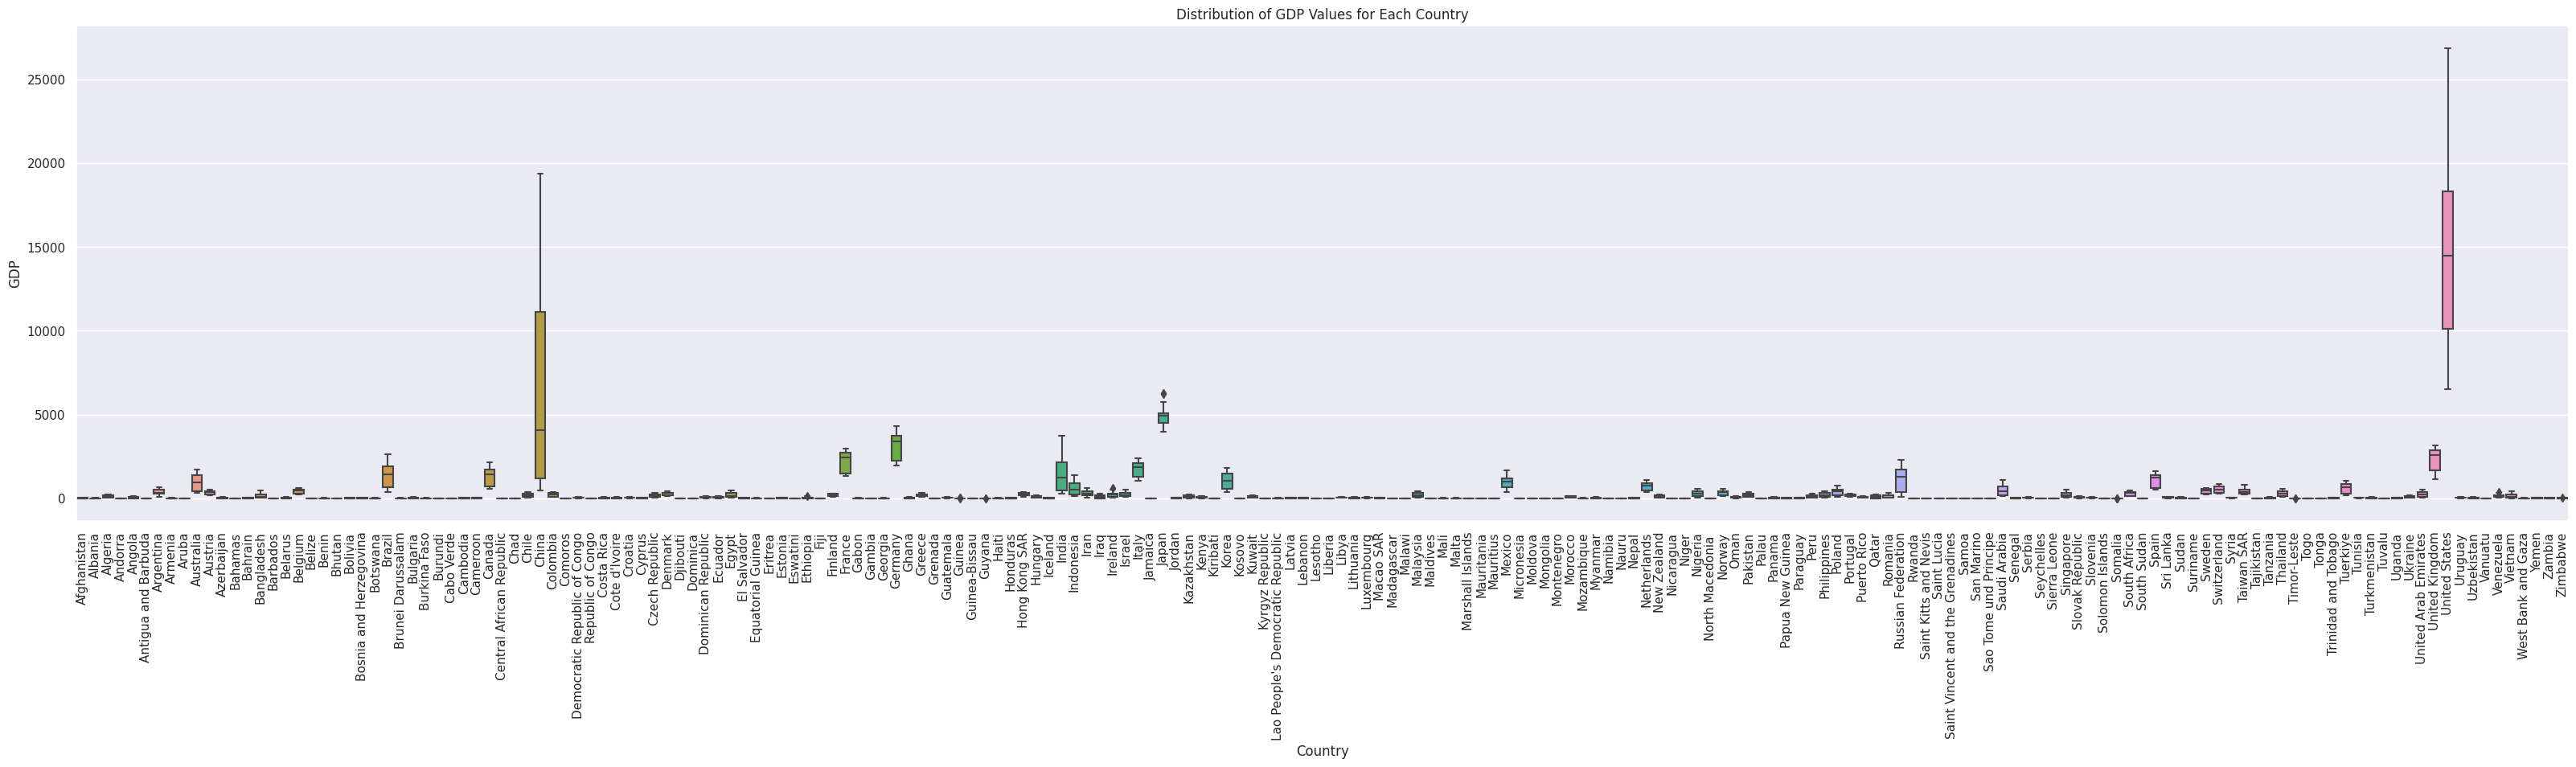

In [195]:
import seaborn as sns

plt.figure(figsize=(40, 8))
sns.boxplot(x='Country', y='GDP', data=gdp)
plt.title('Distribution of GDP Values for Each Country')
plt.xticks(rotation=90) # This makes the country names vertical so they don't overlap
plt.show()

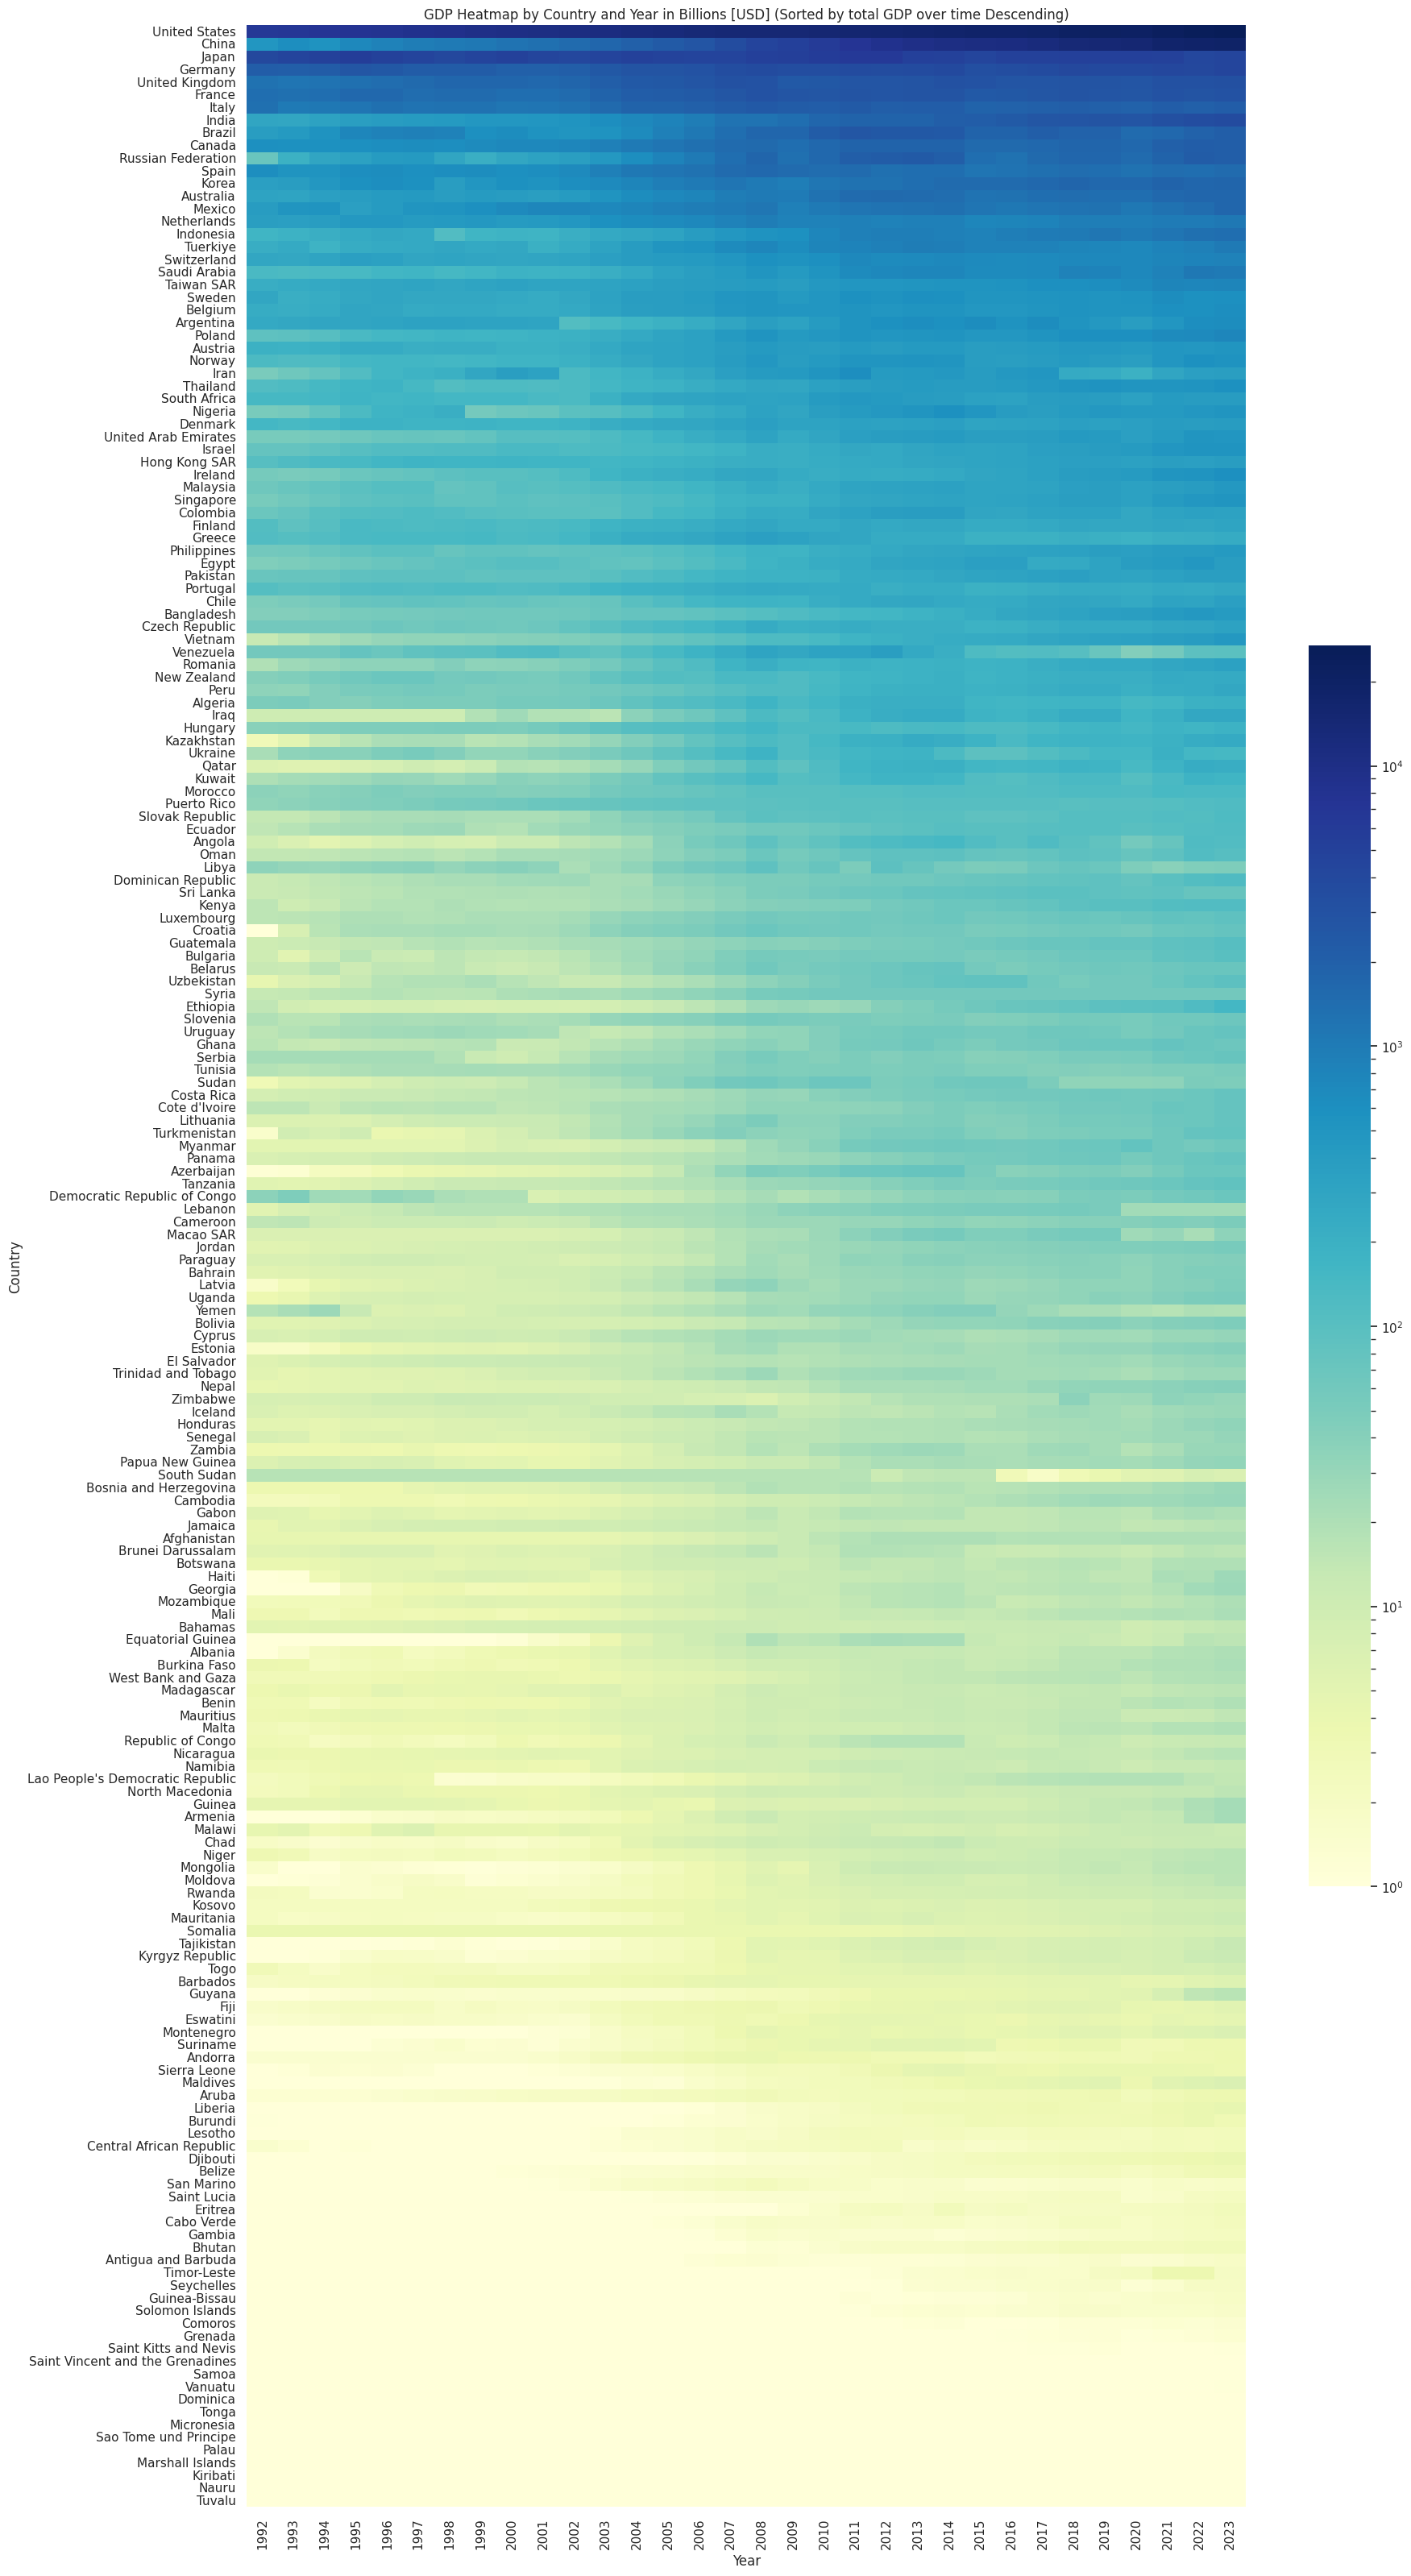

In [196]:
import matplotlib.colors as clrs

def heatmap_normal_scaling_ordered_alphabetical():
    pivot_data = gdp.pivot(index='Country', columns='year', values='GDP')

    plt.figure(figsize=(20, 40))  # Adjust the figure size as needed
    sns.heatmap(pivot_data, cmap='YlGnBu', cbar_kws={"shrink": 0.5})
    plt.xlabel('Year')
    plt.ylabel('Country')
    plt.title('GDP Heatmap by Country and Year')

    plt.show()

def heatmap_log_scaling_ordered_alphabetical():
    pivot_data = gdp.pivot(index='Country', columns='year', values='GDP').fillna(0)

    # Create a heatmap with log scaling for the legend
    plt.figure(figsize=(20, 40))
    sns.heatmap(pivot_data, cmap='YlGnBu', norm=clrs.LogNorm(vmin=1, vmax=pivot_data.values.max()), cbar_kws={"shrink": 0.5})
    plt.xlabel('Year')
    plt.ylabel('Country')
    plt.title('GDP Heatmap by Country and Year (Log Scaling)')


def heatmap_log_scaling_ordered_gdp(): 
    pivot_data = gdp.pivot(index='Country', columns='year', values='GDP').fillna(0)

    # Calculate the total GDP for each country and sort by GDP in descending order
    total_gdp = pivot_data.sum(axis=1)
    sorted_countries = total_gdp.sort_values(ascending=False).index

    # Reorder the rows in the pivot_data DataFrame based on the sorted countries
    pivot_data_sorted = pivot_data.loc[sorted_countries]

    # Create a heatmap with log scaling for the legend
    plt.figure(figsize=(20, 40))
    sns.heatmap(pivot_data_sorted, cmap='YlGnBu', norm=clrs.LogNorm(vmin=1, vmax=pivot_data.values.max()), cbar_kws={"shrink": 0.5})
    plt.xlabel('Year')
    plt.ylabel('Country')
    plt.title('GDP Heatmap by Country and Year in Billions [USD] (Sorted by total GDP over time Descending)')
    plt.show()


#heatmap_normal_scaling_ordered_alphabetical()
#heatmap_log_scaling_ordered_alphabetical()
heatmap_log_scaling_ordered_gdp()

KeyboardInterrupt: 

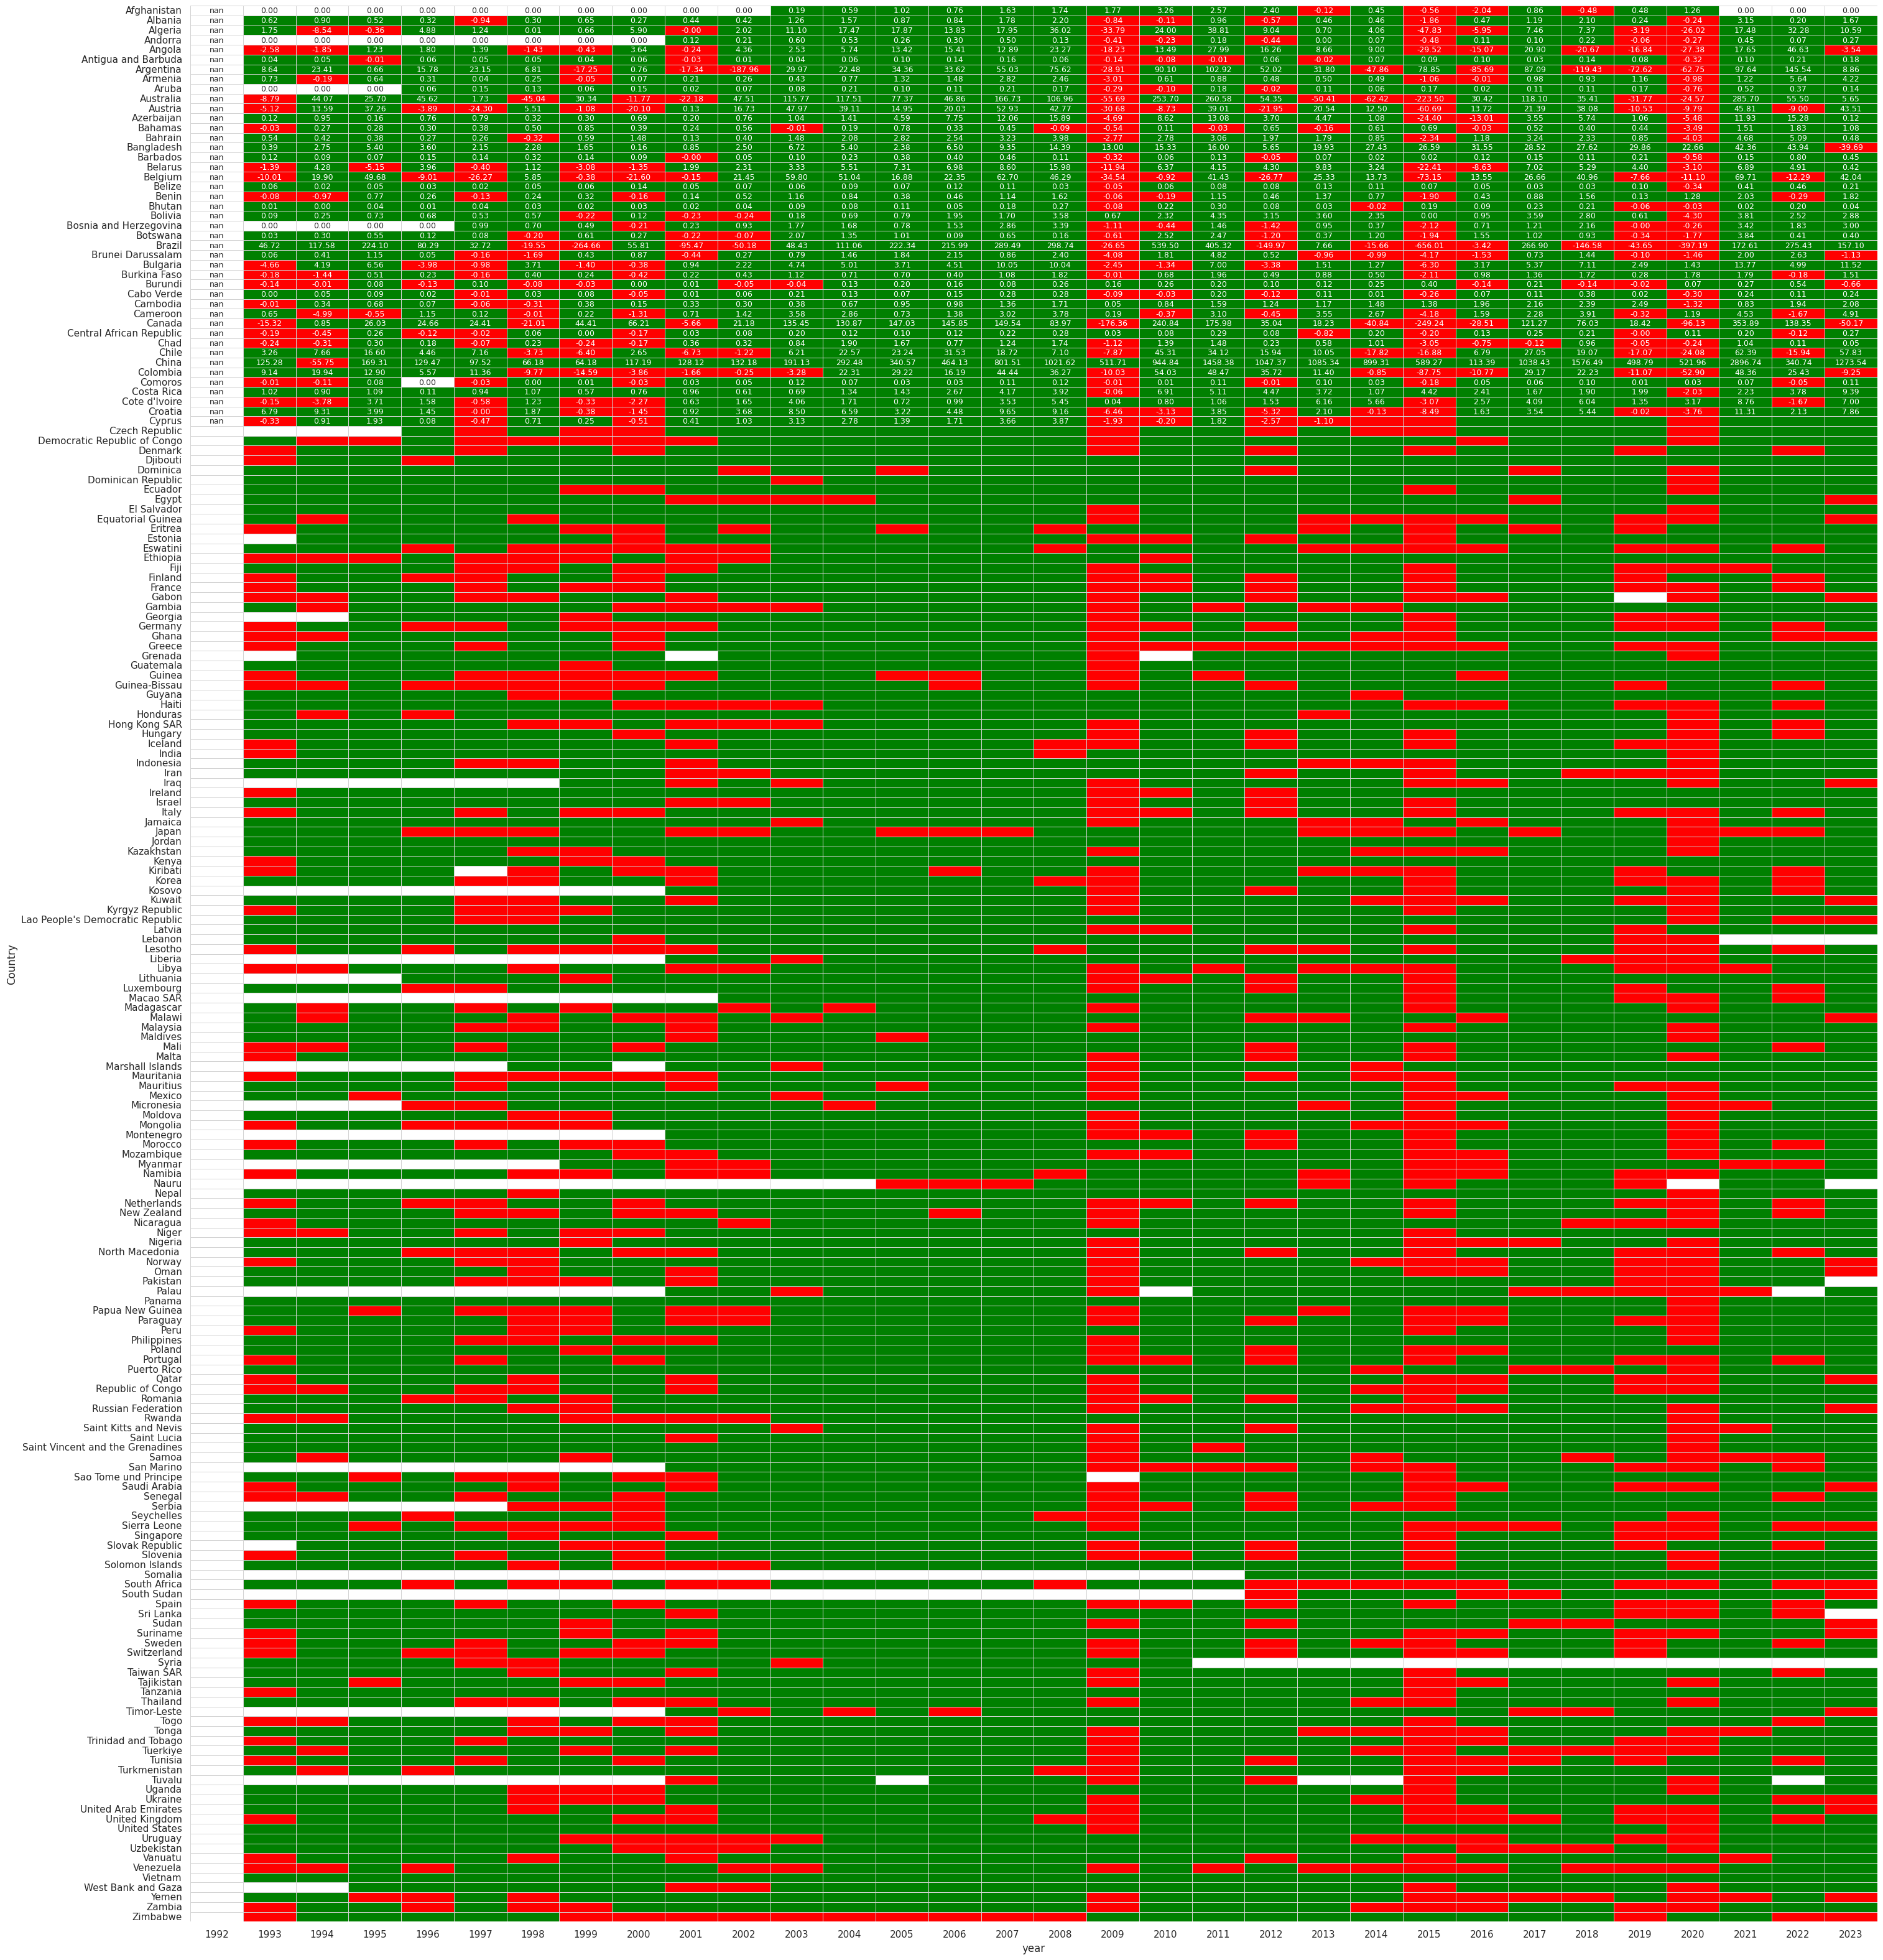

In [197]:
dfh = gdp

dfh['gdp_change'] = dfh.groupby('Country')['GDP'].diff()
dfh['gdp_change_category'] = np.where(dfh['gdp_change'] > 0, 'Increase', np.where(dfh['gdp_change'] < 0, 'Decrease', 'No Change'))


# Create a mapper
mapper = {'Increase': 1, 'No Change': 0, 'Decrease': -1}


# Map the gdp_change_category column to numerical values
dfh['gdp_change_category'] = dfh['gdp_change_category'].map(mapper)


# Pivot the DataFrame to have years as columns and countries as index
df_pivot = dfh.pivot(index='Country', columns='year', values='gdp_change_category')

# Create a colormap
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['red', 'white', 'green'])


# Pivot the data to have each country's GDP as a separate column
pivot_data_labels = gdp.pivot(index='Country', columns='year', values='GDP')

# Calculate the change in GDP for each country from one year to the next
gdp_change_label = pivot_data_labels.diff(axis=1)


# Plot the heatmap
plt.figure(figsize=(35, 40))
sns.heatmap(df_pivot, annot=gdp_change_label, annot_kws={"fontsize":9}, cmap=cmap, cbar=False, linewidths=0.5, linecolor='lightgrey', fmt=".2f")
plt.xlabel('Year')
plt.ylabel('Country')
plt.title('GDP Change Heatmap in Billions [USD] (Green: Increase, Red: Decrease, White: No Change)')

plt.show()

In [ ]:
%%capture
import bar_chart_race as bcr

# Assuming you have already loaded the data into a DataFrame named 'data'
# Let's say the columns are: 'Country', 'Year', 'GDP'

# Pivot the data to have each country's GDP as a separate column
pivot_data_race = gdp.pivot(index='Country', columns='year', values='GDP')
pivot_data_race.columns = pd.to_datetime(pivot_data_race.columns, format='%Y')

# Transpose the DataFrame to have years as columns and countries as rows
pivot_data_race = pivot_data_race.T


# Create the bar chart race animation
bcr.bar_chart_race(
    df=pivot_data_race,
    filename='highest_gdp_comparison.gif',
    orientation='h',       # Horizontal bars
    sort='desc',           # Sort bars in descending order at each frame
    n_bars=20,             # Number of bars (countries) to include in each frame
    steps_per_period=10,   # Number of steps (frames) per year
    period_length=500,     # Length of each period (milliseconds)
    title='Top 20 Countries with Highest GDPs in Billions (USD) with median',
    bar_label_size=7,      # Font size of bar labels
    tick_label_size=7,     # Font size of tick labels
    period_fmt='%Y',       # Show only the year for periodic steps
    shared_fontdict={'family': 'Helvetica', 'color': '.1'},  # Font settings
    filter_column_colors=True,  # Apply the color from the final frame to all frames
    perpendicular_bar_func='median',  # Set the median as the reference line
)

![SegmentLocal](highest_gdp_comparison.gif "segment")

#### b)
Pick a year with as little missing values as possible. <br>
For this year, create an interactive map with `folium` that tells you the GDP in the country in the given year. <br>
*Hint: Be cautious with country names.*

In [ ]:
gdp_05 = gdp[gdp['year']==2005]

In [ ]:
gdp_05.shape

In [ ]:
from geopy.geocoders import Nominatim

# Initialize the geolocator
geolocator = Nominatim(user_agent="geoapiExercises")

# Create a world map
world_map= folium.Map(location=[10, -20], zoom_start=2.3)

# Loop over each country and its GDP
for idx, row in gdp_05.iterrows():
    # Get the location of the country
    location = geolocator.geocode(row['Country'])

    # If the location is found
    if location is not None:
        # Add a marker to the map
        folium.Marker(
            location=[location.latitude, location.longitude], 
            popup=f"Country: {row['Country']}, GDP: {row['GDP']}",
        ).add_to(world_map)

# Show the map
world_map


# Problem 3 - Supervised Machine Learning
#### a)
First, try to predict the GDP in a given year and in a given country using the data from the past years. <br>
Report the performance (measured in mean squared error) for different numbers of lags. 

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
def train_model(df, country, model, lags):
    df_country = df[df['Country']==country].drop('Country', axis=1)
    df_country = df_country.sort_values(by='year').drop('year', axis=1)
    for lag in range(1, lags+1):
        df_country[f'GDP_lag_{lag}'] = df_country['GDP'].shift(lag)
    
    df_country = df_country.dropna()
    X_train, X_test, y_train, y_test = train_test_split(df_country.drop('GDP', axis=1),df_country['GDP'], test_size=.3,  shuffle=False)
    model.fit(X_train, y_train)
    mse = model.score(X_test, y_test)
    return mse

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor

In [ ]:
linear = LinearRegression()
boost = AdaBoostRegressor(n_estimators=50, random_state=0)
forest = RandomForestRegressor(n_estimators = 50, random_state=0)
models = [linear, boost, forest]
rows = []
df = pd.DataFrame(columns=['Country', 'lag', 'model', 'mse'])
for country in gdp['Country'].unique():
    row = {'Country': country}
    for lags in range (1, 6):
        row['lag'] = lags
        for model in models:
            row['model'] = type(model).__name__
            row['mse'] = train_model(gdp, country, model, lags)
            new_row = pd.DataFrame([row], columns=df.columns)
            df = pd.concat([df, new_row], axis=0, ignore_index=True)

df.head()

In [ ]:
df.sort_values(by=['mse'], inplace=True)
df.tail()

#### b)
Now, see if you can improve the prediction with additional data. <br>
In this task, you are supposed to be creative and use your intuition. What could be important predictors? Think of, for example:
- Country characteristics such as population, unemployment rates etc. <br> *Hint: You can search for official statistics, e.g., from OECD.*
- Major historical events such as wars, natural disasters etc. <br> *Hint: You can make dummy variables if such an event happened for given country and year.*
- Geographical information such as continent.

*Note: It is well possible that you can't find data on very small countries. If you don't find data for some countries, you can drop them.*

In [ ]:
# Insert your code here.

# Problem 4 - Unsupervised Machine Learning 
Use GDP and the information from Problem 3b) to cluster countries. <br>
Which is the optimal number of clusters? <br>
Can you provide an intuition for the clusters you identified?

In [ ]:
from sklearn.cluster import KMeans

pivot_data = gdp.pivot(index='Country', columns='year', values='GDP')

# Perform k-means clustering
k = 6  # Change this value to the desired number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(pivot_data)

# Add the cluster labels to the DataFrame
pivot_data['Cluster'] = clusters

# get average gdp per cluster per year
pivot_data = pivot_data.groupby('Cluster').mean()

# display the gdp per cluster per year as a line chart
pivot_data.T.plot(figsize=(15, 10), title='Average GDP per Cluster per Year')

# plot the countries per cluster as a scatter plot
plt.figure(figsize=(15, 10))



In [ ]:
# plot 